# Face detection using Haar-like features

In this notebook you will learn to detect faces in images and videos using Haar-like features.

Requirements:

- scikit-image
- scikit-learn
- matplotlib


## Approach

The proposed approach consists of the following steps:

1. Create a dataset of face and non face patches and split it into train and test sets
2. Extract Haar-like features from the dataset
3. Train a classifier
4. Check the performance of the classifier in the test set

But first, let's import some required libraries


In [32]:
from time import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import skimage
import random

# Classifier + Training
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Haar-like features
from skimage.transform import integral_image, rescale, resize
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature
from sklearn.feature_selection import SelectKBest

from tqdm import tqdm
import itertools
import matplotlib.patches as patches


## Step 1: Create the datasets
In this notebook we are going to use a face database included in the scikit-learn library. 

Number of faces: 13233 | Size of images: (62, 47)


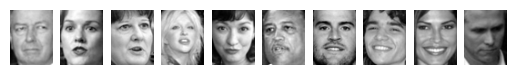

In [3]:
from sklearn.datasets import fetch_lfw_people

faces = fetch_lfw_people()
print(f"Number of faces: {faces.images.shape[0]} | Size of images: {faces.images.shape[1:]}")

fig, ax = plt.subplots(1,10)
for i in range(10):
    ax[i].imshow(faces.images[np.random.randint(0,faces.images.shape[0])], cmap='gray')
    ax[i].axis('off')

In order to compute the Haar-like features and to speed up the computations, we are going to reduce the dataset and resize each input image to a (25,25) square.

(400, 25, 25)


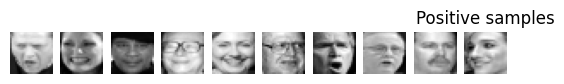

In [6]:
# Parameters
N_SAMPLES = 400
SIZE = (25, 25)

random_samples = np.random.randint(0, faces.images.shape[0], N_SAMPLES)

positive_patches = np.array([skimage.transform.resize(img, SIZE, anti_aliasing=True) for img in faces.images[random_samples]])

print(positive_patches.shape)

fig, ax = plt.subplots(1,10)
plt.title("Positive samples")
for i in range(10):
    ax[i].imshow(positive_patches[np.random.randint(0,positive_patches.shape[0])], cmap='gray')
    ax[i].axis('off')

Since we also need some negative examples, we are going to extract patches from sample images included in the scikit-image library. 

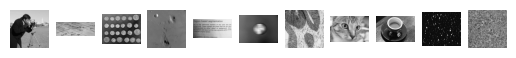

In [4]:
sample_images = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field','grass']
negative_images = []
for name in sample_images:
    img = getattr(skimage.data, name)()
    if len(img.shape) == 3:
            img = skimage.color.rgb2gray(img)
    negative_images.append(img)  
    
fig, ax = plt.subplots(1, len(negative_images))    
for idx,img in enumerate(negative_images):
    ax[idx].imshow(img, cmap='gray')
    ax[idx].axis('off')
plt.show()

From these images we are going to extract some 25x25 patches at different scales:

(495, 25, 25)


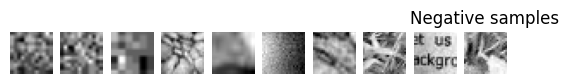

In [7]:
def extract_patches(img, n, patch_size, scale=1.0):
    new_size = (int(scale*patch_size[0]), int(scale*patch_size[1]))
    extractor = sklearn.feature_extraction.image.PatchExtractor(patch_size=new_size, max_patches=n)
    patches = extractor.transform(img[np.newaxis])
    
    if scale != 1:
        patches = np.array([skimage.transform.resize(patch, patch_size) for patch in patches])

    return patches

negative_patches = np.vstack([extract_patches(im, 15, SIZE, scale) 
                                for im in negative_images for scale in [0.5, 1.0, 1.5]])
print(negative_patches.shape)

fig, ax = plt.subplots(1,10)
plt.title('Negative samples')
for i in range(10):
    ax[i].imshow(negative_patches[np.random.randint(0,negative_patches.shape[0])], cmap='gray')
    ax[i].axis('off')

Note that this is a toy face dectector. A real one would need a larger and more complex set of non-face samples.

## Step 2: Extract Haar-like features
There is some functions in the `scikit-image` library to compute haar features from an input image. 

Number of features in an (25, 25) image = 101400


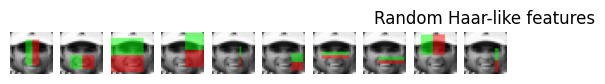

In [69]:
# Extract the haar features for the current image.
# The features specified by 'feature_type'  are computed
# from the integral image only at the positions specified by 'feature_coord'
# If both parameters are none, all the haar features at all the image positions are
# computed
def extract_feature_image(img, feature_type, feature_coord=None):
    
    ii = skimage.transform.integral_image(img)
    features = skimage.feature.haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1],
                             feature_type=feature_type,
                             feature_coord=feature_coord)
    return features

# Parameter
# Types of features to compute (for simplicity, only two)
FEATURE_TYPES = ['type-2-x', 'type-2-y']

# Returns all the coordinates and feature types that can be computed in an image
# of a given size
feature_coord, feature_type =\
    skimage.feature.haar_like_feature_coord(width=SIZE[1], height=SIZE[0],
                            feature_type=FEATURE_TYPES)

print(f"Number of features in an {SIZE} image = {feature_coord.shape[0]}")
fig, ax = plt.subplots(1,10)
plt.title("Random Haar-like features")

for idx in range(10):
    image = positive_patches[0]
    image = skimage.feature.draw_haar_like_feature(image, 0, 0,
                                   SIZE[1],
                                   SIZE[0],
                                   [feature_coord[np.random.randint(0, feature_coord.shape[0])]])
    ax[idx].imshow(image)
    ax[idx].axis('off')
plt.show()

Now, you can compute the Haar-like features from the dataset (it can take a while):

In [70]:
dataset = np.vstack([positive_patches, negative_patches])

t_start = time()
features = np.vstack([extract_feature_image(img, FEATURE_TYPES) for img in dataset])
time_full_feature_comp = time() - t_start

print(f"Computed {features.shape} features in {time_full_feature_comp}s")
        


Computed (895, 101400) features in 196.90912890434265s


Once the features are computed, we can train a classifier in order to distinguish between face and non-face patches. 

To this end, the original approach uses a Cascade Classifier. However, the `scikit-learn` library does not implement this classifier. Even though OpenCV has an implementation of this classifier, it can be only used for inference in python. The training is done by a standalone application that is generated in the compilation of the source code of the library. This way, in this toy example we are going to use a standard classifier to check how the performance of the Haar-like features in the face detection problem.

In [76]:
labels = np.zeros((features.shape[0]))
labels[:positive_patches.shape[0]] = 1 

X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=320, stratify=labels, random_state=0)
clf = RandomForestClassifier()

t_start = time()
clf.fit(X_train, y_train)
time_full_train = time() - t_start
print(f"Training finished in {time_full_train} s")
       

Training finished in 2.3659870624542236 s


We can also check the performance of the classifier in the test set:

In [77]:
predictions = clf.predict(X_test)
print(f"Test success: {np.sum(predictions == y_test)/len(y_test)}")


Test success: 0.9826086956521739


The Random Forest classifier set the importance of each feature in the final decision so we can visualize which are the most important features to distinguish faces:

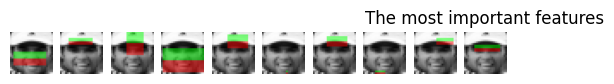

In [13]:
idx_sorted = np.argsort(clf.feature_importances_)[::-1]

fig, ax = plt.subplots(1, 10)

for idx in range(10):
    image = positive_patches[0,:,:]
    image = draw_haar_like_feature(image, 0, 0,
                                   SIZE[1],
                                   SIZE[0],
                                   [feature_coord[idx_sorted[idx]]])
    ax[idx].imshow(image)
    ax[idx].axis('off')

plt.title('The most important features')
plt.show()

### Exercise
Use some [feature selection technique](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection) from the `scikit-learn` library to get the most important features. Train another classifier with these selected  features. Compare this classifier with the previous one in terms of success rate.

*Note*: All the feature selectors from the `scikit-learn` library implement the method `get_support()` that returns a boolean mask where the positions of the selected features are marked as True. You can use this mask to select the Haar-like features to compute in order to speed up the procedure. For example:

In [14]:
# In this example, the mask is manually initialized. In the practice, the
# feature selector computes this mask
mask = np.full(feature_coord.shape, False) 
mask[np.random.randint(0, feature_coord.shape[0], 5)] = True
print(f"Selected features from the first sample: {features[0,mask]}")


# feature_coord and feature_type stores the coordinates and types of all the features
# that can be computed in an input patch. They were computed using the function
# haar_like_feature_coord
print(f"Number of possible features: {feature_coord.shape[0]}")

# Compute only the selected features from the first positive image
sample_features = extract_feature_image(positive_patches[0,:,:], feature_type[mask], feature_coord[mask])
print(f"Features computed using the mask: {sample_features}")


Selected features from the first sample: [-1.19139248 -1.46869589 -7.7152506  -5.9643845   0.4327586 ]
Number of possible features: 101400
Features computed using the mask: [-1.19139248 -1.46869589 -7.7152506  -5.9643845   0.4327586 ]


In [131]:
# Select the 10 most important features

selector = SelectKBest(k=10)
X_train_fs = selector.fit_transform(X_train, y_train)
mask_fs = selector.get_support()
X_test_fs = selector.transform(X_test)
clf_fs = RandomForestClassifier()

# Train
t_start = time()
clf_fs.fit(X_train_fs, y_train)
time_full_train = time() - t_start
print(f"Training finished in {time_full_train} s")

# Test
predictions = clf_fs.predict(X_test_fs)
print(f"Test success: {np.sum(predictions == y_test)/len(y_test)}")

Training finished in 0.22309112548828125 s
Test success: 0.8730434782608696


In [121]:
# Select the 1000 most important features

selector2 = SelectKBest(k=1000)
X_train_fs_2 = selector2.fit_transform(X_train, y_train)
mask_fs_2 = selector2.get_support()
X_test_fs_2 = selector2.transform(X_test)
clf_fs_2 = RandomForestClassifier()

# Train
t_start = time()
clf_fs_2.fit(X_train_fs_2, y_train)
time_full_train = time() - t_start
print(f"Training finished in {time_full_train} s")

# Test
predictions = clf_fs_2.predict(X_test_fs_2)
print(f"Test success: {np.sum(predictions == y_test)/len(y_test)}")

Training finished in 0.46703195571899414 s
Test success: 0.9356521739130435


### Exercise Text Response
As can be seen from the test performance of the classifiers, the feature elemination makes the deterioration of performance in terms of accuracy noticeable. However, it has to be kept in mind that 101400 features are initially available, which is a relatively high value. Therefore, feature removal is a good option to reduce computation time, but not to improve performance in the case of features that are relevant in the classification process.

The results obtained are listed below:
 - 101400 features: 0.982 test accuracy in a training time of 2.36s.
 - 1000 features: 0.935 test accuracy in a training time of 0.46s.
 - 10 features: 0.873 test accuracy in a training time of 0.22s.

As mentioned above, a trade-off must be achieved between a robust feature set that is as short as possible and a reasonable computational time. In this case, more features will allow more detailed profiling of samples, including reflected failures in accuracy for certain samples that cannot be described as accurately by removing features. However, the training computation time also increases a lot, it would have to be found out if the model reflects this increase in prediction time, being a really useful factor from the point of view of the usability of the system in real environments.

### Exercise

Develop a function that receives an image and detects the faces in it using a sliding window approach. Compare the results using all the features as well as the selected features in terms of computational efficiency and success rate.

**Notes**:
- Take into account that the original size of face images in the training dataset was 62x47 and they were resized to 25x25.
- In order to avoid false positives, if you use a Random Forest classifier, use the function `predict_proba` instead of `predict` to get the probabilities of each class. Use a threshold higher than 0.5 to conclude that a window contains a face.



In [133]:
def detect_faces(image, clf, mask=None, orig_size=(62,47), patch_size=(25,25), feature_types=FEATURE_TYPES, stride=7, threshhold=0.6):    
    faces = []
    for x,y in tqdm(list(itertools.product(range(0, image.shape[0] - orig_size[0], stride), range(0, image.shape[1] - orig_size[1], stride)))):
        # Get patch, resize and extract features
        patch = image[x:x+orig_size[0], y:y+orig_size[1]]
        patch = skimage.transform.resize(patch, patch_size)
        features = extract_feature_image(patch, feature_types)
        if mask is not None:
            features = features[mask]
        # Predict
        features = features.reshape(1,-1)
        if clf.predict_proba(features)[0][1] > threshhold:
            #print(clf.predict_proba(features))
            faces.append((x,y))    
    return faces

def plot_results(image, coords, patch_size=(62,47)):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.plot()
    for points in coords:
        # Draw bounding box
        ptch = patches.Rectangle(points, patch_size[1], patch_size[0], fill=False, color='r', linewidth=2)
        plt.gca().add_patch(ptch)
    plt.show()
    

100%|██████████| 196/196 [00:57<00:00,  3.41it/s]

Detect faces using feature selection: 57.543050050735474 s


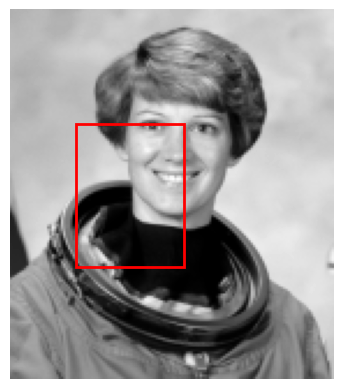

In [118]:
######
# First run - no feature selection (101400 features)
######

# Test image
test_image = skimage.data.astronaut()
test_image = skimage.color.rgb2gray(test_image)
test_image = skimage.transform.rescale(test_image, 0.5)
test_image = test_image[:160, 40:180]

# Detect faces
t_start = time()
coords = detect_faces(test_image, clf, None, threshhold=0.59)
print(f"Detect faces using feature selection: {time()-t_start} s")
plot_results(test_image, coords)

 32%|███▏      | 63/196 [00:18<00:41,  3.21it/s]

[[0. 1.]]


 77%|███████▋  | 151/196 [00:41<00:11,  3.76it/s]

[[0. 1.]]


 79%|███████▉  | 155/196 [00:42<00:10,  3.73it/s]

[[0. 1.]]


 85%|████████▍ | 166/196 [00:45<00:08,  3.51it/s]

[[0. 1.]]


 85%|████████▌ | 167/196 [00:46<00:08,  3.24it/s]

[[0. 1.]]


 91%|█████████ | 178/196 [00:49<00:04,  3.87it/s]

[[0. 1.]]


 95%|█████████▍| 186/196 [00:51<00:02,  3.57it/s]

[[0. 1.]]


 97%|█████████▋| 190/196 [00:52<00:01,  3.36it/s]

[[0. 1.]]


100%|██████████| 196/196 [00:54<00:00,  3.59it/s]

Detect faces using feature selection: 54.63806390762329 s


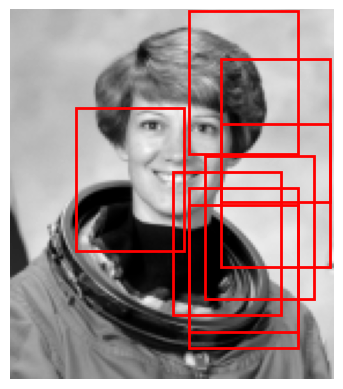

In [132]:
######
# Second run - feature selection (10 features)
######
t_start = time()
coords = detect_faces(test_image, clf_fs, mask_fs, threshhold=0.99)
print(f"Detect faces using feature selection: {time()-t_start} s")
plot_results(test_image, coords)

100%|██████████| 196/196 [00:58<00:00,  3.33it/s]

Detect faces using feature selection: 58.87839603424072 s


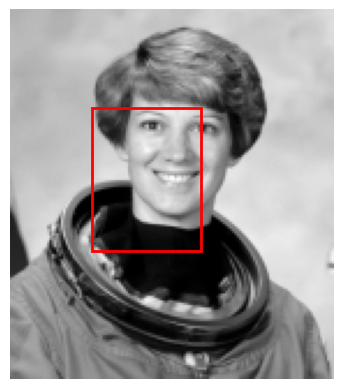

In [125]:
######
# Third run - feature selection (1000 features)
######
t_start = time()
coords = detect_faces(test_image, clf_fs_2, mask_fs_2, threshhold=0.78)
print(f"Detect faces using feature selection: {time()-t_start} s")
plot_results(test_image, coords)

#### Exercise Text Response

First of all, it should be noted that the specific model to be used (Random Forest), due to its operation, does not reflect a problem with the existence of a very high number of features. The computation times are shown below:
 - 101400 features: 57 seconds.
 - 1000 features: 58 seconds.
 - 10 features: 54 seconds.

As for the results, undoubtedly the worst model will be the one with 10 features, which includes multiple false positives with a total certainty. On the other hand, the 1000 features model is the best performer, with a single face detection. Finally, the 101400 features model obtains a similar result to the 1000 features model, but the face detection is somewhat shifted.

As a curiosity, it is worth mentioning the certainty of the models, since when more features are used, the model returns positives with a lower certainty (and more accurate, compared to when very few features are used.), probably caused by the overfitting implied by the use of few features, because as they are not completely representative, samples with the same feature in the train set may be labeled as clear positives.

Finally, the conclusion is the following: both the use of many features will complicate the training unnecessarily with little relevant information (as well as the prediction time in the case of using other models such as neural networks). On the other hand, the use of too few features will imply a serious problem in the representation of samples, degrading the performance of the models.